<a href="https://colab.research.google.com/github/nprimavera/MPC/blob/main/Project3_V12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MECS6616 Spring 2025 - Project 3**

# **Introduction**

***IMPORTANT:***
- **Before starting, make sure to read the [Assignment Instructions](https://courseworks2.columbia.edu/courses/215046/pages/assignment-instructions) page on Courseworks to understand the workflow and submission requirements for this project.**

**FOR PROJECT 3!!!**
- Apart from the link to your notebook, you are also required to submit your collected data `.pkl` files and your chosen model checkpoint `.pth` files to Coursework. You will have two files each for parts 2 and 3 for a total of 4 files.
- Your part 2 files should be named `data_pt2.pkl` and `dynamics_pt2.pth`.
- Your part 3 files should be named `data_pt3.pkl` and `dynamics_pt3.pth`.
- You should put the link to your notebook in the "Comment" section of your submission.

## **Project Setup (do NOT change)**

***IMPORTANT:***
- Do NOT change this "*Project Setup*" section
- Do NOT install any other dependencies or a different version of an already provided package. You may, however, import other packages


In [1]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp25_project3' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp25_project3.git

Cloning into 'mecs6616_sp25_project3'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 50.76 KiB | 4.61 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
# DO NOT CHANGE

# move all needed files into the working directory. This is simply to make accessing files easier
!mv /content/mecs6616_sp25_project3/* /content/

In [3]:
# Using ray for data collection is optional
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 10.6 MB/s eta 0:00:00


# Starter Code Explanation

This project uses a simulated robot provided by the `Robot` class in `robot.py` file. Each robot is initialized with a corresponding forward dynamics (the base class for forward dynamics definition is in `arm_dynamic_base.py`). The arm_teacher is initialized with the provided ground truth forward dynamics, as defined in `arm_dynamics_teacher.py`. You are welcome to look in-depth into this file to understand how the ground truth forward dynamics is computed for an arm, given its number of links, link mass, and viscous friction of the environment - this is recommended but not necessary to successfully complete this assignment.

The Robot class inside `robot.py` which provides the interface for controlling the robot arm i.e it provides you with some functions to set/get the state and set the action for the arm and take a step using the `Robot.advance()` method. The state of the arm is a 2n-dimensional vector: n joint positions [rad] + n joint velocities [rad/s] and the action is defined as the n torques (in N-m) applied to n joints respectively.

In addition to `arm_dynamics_teacher.py` which contains the ground truth forward dynamics, you will use `arm_dynamics_student.py`, the student dynamics which internally uses a neural network model.

# Part 1: Implement Model Predictive Control



You will implement this controller by completing the MPC class. Specifically, you will implement the compute_action() method by following the algorithm discussed in the lecture. As with previous projects you are free to implement additional methods as needed or change the initialization if need be. While scoring your controller, you will be creating an instance of the MPC class and passing it to the scoring function so ensure that the arguments to the compute_action method remain the same.

Although you do not need to understand how the ArmDynamicsTeacher class works, you could use the compute_fk() method from the class. This will allow you to convert from the state value (represented as array of shape (2*n, 1) where n is num_links) to final end effector position (x, y position of the end effector). Similary we can also compute the velocity of the end effector with the code below:
```
pos_ee = dynamics.compute_fk(state)
vel_ee = dynamics.compute_vel_ee(state)
```


In [4]:
import numpy as np
from collections import defaultdict

class MPC:
    def __init__(self, num_links, control_horizon=10):
        self.num_links = num_links
        self.control_horizon = control_horizon if num_links == 1 else control_horizon + 5  # Increase horizon for more links
        self.previous_controls = None  # Store previous control solutions for warm-starting

        self.constant_step = 0.005  # remains constant
        self.current_step = 0.005   # changes dynamically
        self.position_weight = 2.0 # constant position weight
        self.velocity_weight = 1.0  # constant velocity weight

    def cost_function(self, state, control, goal):
        pos_error = np.linalg.norm(state[:2] - goal)  # Position error term
        vel_error = np.linalg.norm(state[2:])  # Velocity penalty
        torque_penalty = np.linalg.norm(control) * 0.01 if self.num_links > 1 else 0  # Small torque penalty
        return pos_error + 0.5 * vel_error + torque_penalty

    def solve(self, initial_state, goal):
        best_control = np.zeros(self.num_links)  # Default control guess
        best_cost = float('inf')

        # Use previous control as an initial guess for NUM_LINKS > 1
        if self.previous_controls is not None:
            initial_guess = self.previous_controls
        else:
            initial_guess = np.zeros((self.horizon, self.num_links))

        for i in range(100):  # Optimization loop
            candidate_control = initial_guess + np.random.randn(*initial_guess.shape) * 0.1
            new_state = self.simulate_dynamics(initial_state, candidate_control)
            cost = self.cost_function(new_state, candidate_control, goal)

            if cost < best_cost:
                best_cost = cost
                best_control = candidate_control[0]

        self.previous_controls = best_control  # Save for warm start
        return best_control

    def simulate_dynamics(self, state, control):
        """Simulate the system forward (dummy function, replace with actual dynamics)."""
        return state + control  # Placeholder

In [5]:
"""
Forward Models:  x_k+1 = f(x_k, u_k)
    - x_k - state of the system at time step k
    - u_k - action/command given to the robot at time step k
    - x_k+1 - state of the system at the next time step, k+1
    - using discretized time - size of time step Δt not explicitly part of forward model, but often very important
    - Long Rollouts
      - forward model that only predicts the next time step can still be used to look arbitrarily far into the future (if actions are given)
      - errors quickly start compounding and the model diverges

State - everything that "characterizes" your system

Markovian property - state vector at current time step has everything you need to know about previous state vectors

Kinematic Chain Dynamics:
    - Torque-controlled dynamic robot arm
        - x_k = (q, q_dot) - vectors of joint positions and velocities
        - u_k = u - vector of applied joint torques
        - x_k+1 = ?
    - None of these are explicitly included in the state
      - link masses
      - inertial tensors
      - externally applied forces (gravity)
      - obstacles
    - Transient contact makes analytical models of dynamics incredibly difficult
      - linear law like F=ma no longer tells the full story since
        - reaction forces are non-linear in relative object positions
        - friction forces are non-linear in relative object velocity
      - drastic changes (i.e. new contact) can occur in the middle of a time step
        - must be handled in non-physical ways
      - states that look very similar can be have drasticallty different

Remember: analytical model of kinematic chains as ground truth
    ● Step 1: solve for joint accelerations q
      ○ Newton’s method: f = ma (for both forces and torques)
      ○ Additional constraints ensure the arm is not coming apart
      ○ Ends up as a big linear system of equations that you can solve for q
    ● Step 2: numerical integration
      ○ Exact:
        ■ q_dot_k+1 = q_dot_k + ∫q_dot_dot(t)dt
        ■ q_k+1 = q_k + ∫q_dot(t)dt
      ○ Euler integration (linear!):
        ■ q_dot_k+1 =q_dot_k +q_dot_dot_k * Δt
        ■ q_k+1 = q_k + q_dot_k * Δt + 0.5 * q_dot_dot_k * Δt^2
      ○ Much better schemes: Runge-Kutta, etc.

Use your "domain knowledge" to inform the architecture of your model --> we know how dynamics work

Overfit what the robot will need to do
"""

import numpy as np
from collections import defaultdict

class MPC:

    def __init__(self, dynamics, initial_control_horizon=10):
        self.control_horizon = 10  # Define control horizon
        #self.control_horizon = initial_control_horizon
        self.num_links = dynamics.get_num_links()
        #self.action = np.zeros((dynamics.get_action_dim(), 1))   # should be (3, 1)
        #self.best_action = np.zeros((self.num_links, 1))  # (3, 1) same as action shape
        #self.best_cost = np.inf
        #self.initial_state = np.array(state)
        self.constant_step = 0.005  # remains constant
        self.current_step = 0.005   # changes dynamically
        self.position_weight = 2.0 # constant position weight
        self.velocity_weight = 1.0  # constant velocity weight

    #def adjust_control_horizon(self, distance_to_goal, velocity_of_ee):

        # Dynamically adjust control horizon
        #if distance_to_goal > 1.0:
            #self.control_horizon = 20  # Longer horizon for far away goals
        #else:
            #self.control_horizon = 10  # Shorter horizon for closer goals

    def dynamic_step(self, distance_to_goal, current_velocity):
        """
        Adjust step size based on distance & velocity dynamically
          - start from 1
          - add (0.5 * dist_to_goal) --> the farther the goal, the larger the adjustment
          - add (0.5 * np.linalg.norm(current_velocity)) --> the higher the velocity, the larger the adjustment
          - computes the new step size based on the sum of the two adjustments and ensures it doesn't go below 0.001
        """
        scale_factor = 1 + 0.5 * distance_to_goal + 0.5 * np.linalg.norm(current_velocity) + 1e-6
        #scale_factor = min(1 + 0.5 * distance_to_goal + 0.5 * np.linalg.norm(current_velocity), 10) # clipped to avoid very small step sizes
        new_step = max(self.constant_step / scale_factor, 0.001)
        return new_step

    def dynamic_weight(self, distance_to_goal, current_velocity):
        """
        Adjust position & velocity weights dynamically
          - use a sigmoid function (returns b/w 0 and 1) to smoothly adjust position weight based on distance to goal
          - (2 / (1 + np.exp(-distance_to_goal)) - 1) maps the weight adjustment between -1 and 1
          - the further the goal, the higher the weight
          - takes the magnitude (norm) of the current velocity
          - caps the velocity at 1
          - weight increases as the velocity increases
        """
        updated_position_weight = self.position_weight * (2 / (1 + np.exp(-distance_to_goal)) - 1)
        #updated_position_weight = self.position_weight * (1 + np.tanh(distance_to_goal))
        updated_velocity_weight = self.velocity_weight * (1 + min(np.linalg.norm(current_velocity), 1))
        return updated_position_weight, updated_velocity_weight

    def arm_dynamics(self, dynamics):
        # Available functions in arm_dynamics_teacher
        print("\nFunctions in dynamics_teacher:")
        print(dir(dynamics))
        #print(dir(dynamics_teacher))

        # Index of the force in the list of variables - each link has two forces
        idx_f = dynamics.idx_f(0)
        print(f"\nIndex of the force in the list of variables - each link has two forces (idx_f): {idx_f}")

        # Returns the index of acceleration for a link
        idx_a = dynamics.idx_a(0)
        print(f"Returns the index of acceleration for a link (idx_a): {idx_a}")

        # Returns the index of angular acceleration for a link
        idx_omdot = dynamics.idx_omdot(0)
        print(f"Index of angular acceleration for a link (idx_omdot): {idx_omdot}")

        # Total number of variables: position, velocity, angular velocity, forces, acceleration, torques
        num_vars = dynamics.num_var()
        print(f"Total number of variables (num_vars): {num_vars}")

    def initial(self, dynamics, state, goal):
        # Initial variables for action sequence
        print(f"\nInitial action (should be zero): {self.action.reshape(-1)}") # error handling
        print(f"Number of links: {self.num_links}")
        print(f"Best cost (initially): {self.best_cost}")
        print(f"Best action (initially): {self.best_action.reshape(-1)}")

        # Initial State
        print(f"Initial State: {self.initial_state.reshape(-1)}")

        # Initial End-Effector position and velocity
        pos_ee = dynamics.compute_fk(self.initial_state)  # Get end effector position
        vel_ee = dynamics.compute_vel_ee(self.initial_state)  # Get velocity of end effector
        print(f"Initial End-Effector position: {pos_ee.reshape(-1)}, Initial End-Effector velocity: {vel_ee.reshape(-1)}")
        print(f"Goal: {goal.reshape(-1)}")

        # Initial deviation from Goal
        distance_to_goal = np.linalg.norm(goal - pos_ee)  # Compute distance to goal
        velocity_of_ee = np.linalg.norm(vel_ee)  # Compute velocity of end effector
        print(f"\nInitial distance to goal: {distance_to_goal}, Initial velocity: {velocity_of_ee}")

    #def compute_best_action(self, action, pos_ee, goal, current_step):

        # Compute how far the end-effector is from the goal
        #end_effector_dist = pos_ee - goal   # vector

        # Initialize empty vector with the correct shape for action
        #new_action = np.zeros_like(action) # Ensures new_action has the same shape as action

        # Map end-effector error to each joint action
        #for i in range(action.shape[0]): # Iterates over the number of joints in action

            #new_action[i, 0] = -end_effector_dist.flatten()[i % 2] * self.current_step

        #return action + new_action

    def compute_best_action(self, action, dynamics, pos_ee, vel_ee, goal, current_step):

        # Proportional-Derivative (PD) control-based action computation
        end_effector_dist = pos_ee - goal   # vector of errors - EE dist from goal
        velocity_error = vel_ee

        # Initialize empty vector with the correct shape for action
        #new_action = np.zeros_like(action) # Ensures new_action has the same shape as action
        action_update = np.zeros_like(action)

        # Map end-effector error to each joint action
        for i in range(action.shape[0]): # Iterates over the number of joints in action

            #new_action[i, 0] = -end_effector_dist.flatten()[i % 2] * self.current_step

            velocity_error_component = velocity_error[i % velocity_error.shape[0], 0]
            action_update[i, 0] = -self.position_weight * end_effector_dist.flatten()[i % 2] - self.velocity_weight * velocity_error_component

        #return action + new_action

        # Add scaled action update to the current action
        new_action = action + action_update * self.current_step

        return new_action

    #def compute_best_action(self, action, dynamics, goal, pos_ee, vel_ee):

        # Compute how far the end-effector is from the goal
        #ee_dist_to_goal = pos_ee - goal  # vector
        #ee_dist_to_goal = ee_dist_to_goal.flatten()  # flatten the vector into a 1D array
        #ee_dist_to_goal = np.squeeze(ee_dist_to_goal)  # Ensure it's 1D

        # Ensure `ee_dist_to_goal` has correct shape for `num_links`
        #if self.num_links == 1:
            #ee_dist_to_goal = np.array([ee_dist_to_goal[0]])  # Use only first element

        #print(f"Shapes - goal: {goal.shape}, pos_ee: {pos_ee.shape}, ee_dist_to_goal: {ee_dist_to_goal.shape}")

        # Initialize new action vector
        #new_action = self.action  # zeros to start - will store corrections based on ee_dist_to_goal
        #new_action = np.zeros((self.num_links, 1))
        #new_action = np.zeros_like(action)

        # Map end-effector error to each joint action
        #for i in range(self.num_links):
            #correction = -self.current_step * ee_dist_to_goal#[i % len(ee_dist_to_goal)]
            #new_action[i, 0] = correction
            #new_action[i, 0] = -ee_dist_to_goal[i % 2] * self.current_step

        #action += new_action
        #updated_action = action + new_action

        #print(f"Action shape: {action.shape}, New action shape: {new_action.shape}")
        #print(f"Updated Action: {updated_action.reshape(-1)}")

        #return updated_action
        #return self.action
        #return new_action

    def compute_action(self, dynamics, state, goal, action):
        """
        Computes the optimal action using Model Predictive Control (MPC).
            - dynamics: ArmDynamicsTeacher instance
            - state: Current state of the system
            - goal: Desired goal state
            - action: Initial action guess
            - return: Optimal action array of shape (num_links, 1)  -  (3, 1)

        Forward Model Architecture:
            - feed forward the state (position, velocity) and action into the MLP
            - MLP outputs the acceleration
            - use Euler integration to get you new state (new position, new velocity)
            - compare to the ground truth (loss function)

        Must return an array of shape (num_links, 1) - Action shape --> should be (3,1) since there are 3 links
        """

        # Information about robot arm
        #self.arm_dynamics(dynamics)  # prints values

        # Initial values
        #self.initial(dynamics, state, goal)  # prints values

        # Initialize values for best action (3, 1)
        #action = np.zeros((dynamics.get_action_dim(), 1))   # should be (3, 1)
        self.best_action = np.zeros((self.num_links, 1))  # (3, 1) same as action shape
        self.best_cost = np.inf  # Initialize best cost to infinity

        # Initialize state to avoid overwriting input state
        #updated_state = np.array(state, dtype=np.float64)
        #print(f"\nUpdated state: {updated_state.reshape(-1)}")

        # Iterate through the control horizon - "roll out"
        for _ in range(self.control_horizon):

            # Predicting next state, position & velocity of End-Effector
            #self.forward_model(dynamics, state, goal, action)
            #next_state, pos_ee, vel_ee = self.forward_model(dynamics, updated_state, goal, action)  # forward model to predict next state
            #next_state, pos_ee, vel_ee = self.forward_model(dynamics, state, goal, action)  # forward model to predict next state
            next_state, pos_ee, vel_ee, distance_to_goal, self.current_step, self.dynamic_position_weight, self.dynamic_velocity_weight = self.forward_model(dynamics, state, goal, action)
            #print(f"\nNext state: {next_state.reshape(-1)}, End-Effector position: {pos_ee.reshape(-1)}, End-Effector velocity: {vel_ee.reshape(-1)}")

            # Adjust control horizon and weights dynamically
            distance_to_goal = np.linalg.norm(goal - pos_ee)  # Distance to goal
            #self.adjust_control_horizon(distance_to_goal, vel_ee)  # Adjust control horizon based on distance
            self.current_step = self.dynamic_step(distance_to_goal, vel_ee)  # Adjust step size based on distance and velocity
            self.dynamic_position_weight, self.dynamic_velocity_weight = self.dynamic_weight(distance_to_goal, vel_ee)  # Adjust weights dynamically
            #print(f"\nCurrent step: {self.current_step}, Position weight: {self.dynamic_position_weight}, Velocity weight: {self.dynamic_velocity_weight}")

            # Evaluate cost
            #self.cost_function(state, goal, action)
            cost = self.cost_function(pos_ee, goal, vel_ee, action)
            #print(f"Cost: {cost}")

            # Compute best action
            #if cost < best_cost:
                #best_cost = cost
                #best_action = action.copy()
                #print(f"Best cost: {best_cost}")
                #print(f"Best action: {best_action.reshape(-1)}")

            # Compute new action
            #self.compute_best_action(dynamics, goal)
            #new_action = self.compute_best_action(dynamics, action, goal, pos_ee, vel_ee)
            #print(f"New action: {action.reshape(-1)}")
            #action = self.compute_best_action(action, dynamics, goal, pos_ee, vel_ee)
            #print(f"Updated action: {action.reshape(-1)}")
            action = self.compute_best_action(action, dynamics, pos_ee, vel_ee, goal, self.current_step)

            # Update state for next iteration
            #state = self.next_state
            #updated_state = next_state
            #print(f"Updated state: {updated_state.reshape(-1)}")
            state = next_state
            #print(f"Updated state: {next_state.reshape(-1)}")

        #print(f"\n    - Next state: {next_state.reshape(-1)}")
        #print(f"    - End-Effector position: {pos_ee.reshape(-1)}")
        #print(f"    - End-Effector velocity: {vel_ee.reshape(-1)}")
        #print(f"    - Current step: {self.current_step}")
        #print(f"    - Dynamic position weight: {self.dynamic_position_weight}")
        #print(f"    - Dynamic velocity weight: {self.dynamic_velocity_weight}")
        #print(f"    - Cost: {cost}")
        #print(f"    - Action: {action.reshape(-1)}\n")

        return self.best_action

    def forward_model(self, dynamics, state, goal, action):

        # Current state
        #self.state = state

        # Forward simulation of next state to get the dynamics of the system using Euler integration method (dynamics_step)
        """
        def advance(self, state, action):
            #Forward simulation to compute new state given state and action
            start_time = time.time()
            dt = self.dt
            new_state = self.dynamics_step(state, action, dt)
            self.cpu_time_consumed += time.time() - start_time
            return new_state
        """
        next_state = dynamics.advance(state, action)  # predict next state using system dynamics
        #next_state = dynamics.step(state, action)

        # Compute position and velocity of end-effector at next state
        pos_ee = dynamics.compute_fk(next_state)[:2, :]
        vel_ee = dynamics.compute_vel_ee(next_state)[:2, :]

        # Dynamically adjust steps and weights
        distance_to_goal = np.linalg.norm(goal - pos_ee)
        self.current_step = self.dynamic_step(distance_to_goal, vel_ee)
        self.dynamic_position_weight, self.dynamic_velocity_weight = self.dynamic_weight(distance_to_goal, vel_ee)

        return next_state, pos_ee, vel_ee, distance_to_goal, self.current_step, self.dynamic_position_weight, self.dynamic_velocity_weight

    def cost_function(self, pos_ee, goal, vel_ee, action):

        """Quadratic Cost function: J = SUM_(i=k)^(N-1) α*||x_d - x_i||^2 + β*||u_i||^2"""

        # Position error term:  α * ||x_d - x_i||^2
        position_error = np.linalg.norm(pos_ee - goal) ** 2  # calculates the squared Euclidean distance b/w the current end-effector position and the goal
        #position_error = np.sum((pos_ee - goal) ** 2)

        # Velocity term:  β * ||u_i||^2
        velocity_error = np.linalg.norm(vel_ee) ** 2  # calculates the squared norm of the control action
        #velocity_error = np.sum(vel_ee ** 2)

        # Normalize pos & vel error terms
        position_error = (np.linalg.norm(pos_ee - goal) ** 2) / max(1.0, np.linalg.norm(goal))
        velocity_error = (np.linalg.norm(vel_ee) ** 2) / max(1.0, np.linalg.norm(vel_ee) + 1e-6)

        # Torque error term
        torque_penalty = np.linalg.norm(action) ** 2  # Penalize large torques

        # Cost function
        #alpha=1.0 # position weight
        #eta=0.1  # velocity weight
        #cost = alpha * position_error + beta * control_effort
        cost_function = position_error * self.dynamic_position_weight + velocity_error * self.dynamic_velocity_weight #+ torque_penalty * 0.1

        if cost_function < self.best_cost:

            self.best_cost = cost_function
            self.best_action = action.copy()

        return cost_function

## Manually testing the controller
This part is for you to manually check the performance of your controller before you are ready for it be evaluated by our scoring function.
To test your implementation run the following code. Feel free to play around with the cell or change the num_links / goal positions . You can define your controller however you would like to and then switch on gui to see how close your end effectors get to the goal position

Every time step within the environment is 0.01s, which is defined in the dynamics as `dt`.

The MPC class has a `control_horizon` variable which represents the frequency at which `controller.compute_action()` will be called

In the scoring function you will be evaluated on the distance of your end effector to the goal position and the velocity of the end effector.

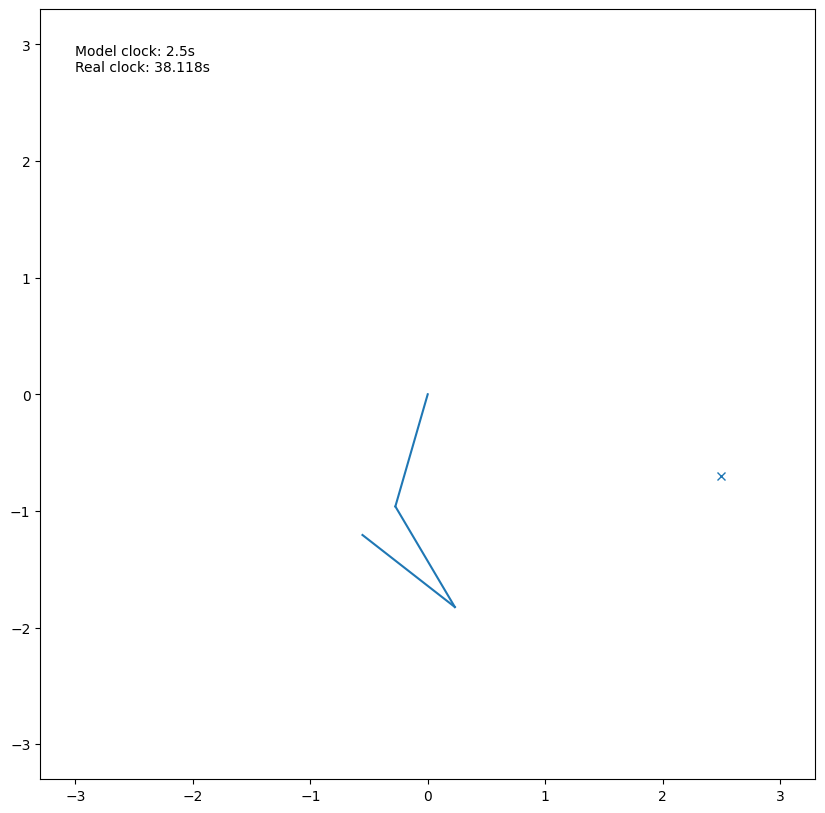

In [6]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time
import math
np.set_printoptions(suppress=True)

# Teacher arm with 3 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=3,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

#gui = True
gui = True

if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC(dynamics_teacher)
#controller = MPC()

# Resetting the arm will set its state so that it is in the vertical position,
# and set the action to be zeros
arm.reset()

# Choose the goal position you would like to see the performance of your controller
goal = np.zeros((2, 1))
goal[0, 0] = 2.5
goal[1, 0] = -0.7
arm.goal = goal

dt = 0.01
time_limit = 2.5
#time_limit = 5.0
num_steps = round(time_limit/dt)

# Initial action (start with zeros)
action = np.zeros((arm.dynamics.get_action_dim(), 1))

# Control loop
for s in range(num_steps):
  t = time.time()
  arm.advance()

  if gui:
    renderer.plot([(arm, "tab:blue")])
  time.sleep(max(0, dt - (time.time() - t)))

  if s % controller.control_horizon==0:
    state = arm.get_state()

    # Measuring distance and velocity of end effector
    pos_ee = dynamics_teacher.compute_fk(state)
    dist = np.linalg.norm(goal-pos_ee)
    vel_ee = np.linalg.norm(arm.dynamics.compute_vel_ee(state))
    print(f'At timestep {s}: Distance to goal: {dist}, Velocity of end effector: {vel_ee}')

    action = controller.compute_action(arm.dynamics, state, goal, action)
    arm.set_action(action)

## Grading and Evaluation for Part 1
Your controller will be graded on 6 tests. 2 tests each for the 1-link ,2-link, and 3-link arms. The arm will start off in the initial state with the arms pointing stright down. The testing criteria depend on the distance and the velocity of the end effectors . Each test will run the robot arm for **5.0 seconds**. At the end of the 5 seconds the test will be:

A success if your end effectors meet this criteria:
`distance_to_goal < 0.1 and vel_ee < 0.5`

A partial success if your end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5`

After all of the tests, your score is summed up and then scaled out of 5 points.


In [7]:
# Scoring using score_mpc
#controller = MPC()
controller = MPC(dynamics_teacher, state)
gui = False

In [8]:
# DO NOT CHANGE
score_mpc_true_dynamics(controller, gui)


Part1: EVALUATING CONTROLLER (with perfect dynamics)
-----------------------------------------------------
NUM_LINKS: 1
Test  1
Success! :)
 Goal: [ 0.38941834 -0.92106099], Final position: [ 0.39129442 -0.92026555], Final velocity: [0.]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-0.68163876 -0.73168887], Final position: [-0.67070199 -0.74172693], Final velocity: [0.]
score: 1.0/1.0
NUM_LINKS: 2
Test  1
Success! :)
 Goal: [ 0.6814821  -1.61185674], Final position: [ 0.63924169 -1.68480972], Final velocity: [0.09649059]
score: 1.5/1.5
Test  2
Fail! :(
 Goal: [-1.19286783 -1.28045552], Final position: [ 0. -2.], Final velocity: [0.]
score: 0/1.0
NUM_LINKS: 3
Test  1
Fail! :(
 Goal: [ 1.29444895 -2.36947292], Final position: [-0.74046346 -1.91517232], Final velocity: [3.01443306]
score: 0/1.5
Test  2
Fail! :(
 Goal: [-2.10367746 -1.35075576], Final position: [-0.03644108 -2.71923701], Final velocity: [1.82799419]
score: 0/1.0
       
-------------------------
Part 1 SCORE:  2.66666666666

# Part 2: Learning Forward Dynamics

### Background Information

From here on, you will only be working with a 2-link arm.

In part 2, you will be training a model that learns the ground truth dynamics of a 2-link arm. This part uses two 2-link arms, one called arm_teacher (blue) and the other called arm_student (red), as shown in the image below. For each test, a torque will be applied to the first joint of both arms for 5 seconds. arm_teacher is moving according to the provided ground truth forward dynamics and your job is to use deep learning to train the arm_student to learn the forward dynamics of arm_teacher so that it can imitate its behavior. The forward dynamics is a function that takes in the current state of an action applied to the arm, and then computes the new state of the arm. This part uses a time step of 0.01 second, meaning each time we advance the simulation, we compute the forward dynamics for 0.01 second. In the example image, the student arm is not updating its state and remains static but we will make it move after training is done.

<div>
<img src="https://github.com/roamlab/mecs6616_sp25_project3/blob/main/imgs/example.png?raw=true" width="600"/>
</div>

The state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second). An action is defined as the two torques (in Nm) applied to the two joints respectively, which is a (2,1) numpy array. **Throughout this part, we make the problem simpler by only applying a torque to the first joint, so the actions always look like `[torque,0]`.** Also, when scoring your model the robot will always start off in a hanging position, meaning an initial state of `[-pi/2,0,0,0]` so if the collected data from part 2.1 looks similar, the model will perform better. The `robot.py` file provides you with some functions to set/get the state and set the action for the arm. Make sure you understand `robot.py` well enough before getting started.

`geometry.py` provides some geometry functions, `render.py` defines how the visualization is rendered, `custom_plot.py` provides data visualization functionality. These three files are not of particular interest for completing this part.

## Part 2.1: Collecting Data

You will first need to complete the cell below to collect a dataset for training the forward dynamics. After running the cell, it should generate a pickle file `data_pt2.pkl` that contains a data dictionary `data = {'X': X, 'Y': Y}`. The shape of `data['X']` should be (`num_samples`, 6), the first 4 elements are state and the last 2 elements are the action. The shape of `data['Y']` should be (`num_samples`, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher. You are responsible for deciding and collecting an appropriate amount of samples. Thus, num_samples is entirely up to you and your model.

**After the data file is generated, `data_pt2.pkl` should appear under the 'Files' icon in the left sidebar. You can download this file by right clicking the file name. You are required to submit this file. Please do not change its name.**

In the cell below, we have provided a minimal example of simulating the arm_teacher for 5 seconds. The GUI visualization is turned on and you should see the behavior of arm_teacher. The visualization can drastically slow down the simulator and you should turn it off when collecting a large amount of data.

In [9]:
import numpy as np
import os
import pickle
import math
import time
import random

from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from custom_plot import plot_positions_velocities_with_fixed_bounds

import ray  # Import Ray for parallel processing

# Initialize ray for parallel processing (speeds up training) - it was actually slower using Ray
#if ray.is_initialized():
    #ray.shutdown()
#ray.init()

#@ray.remote

# Seeding - the randomly initialized weights of the neural network should be made repeatable using seeding
def set_seed(seed_value=42):
    random.seed(seed_value)        # Python's random module
    np.random.seed(seed_value)     # NumPy
    #torch.manual_seed(seed_value)  # PyTorch for CPU

# Simulation function for a single torque value
def simulate_torque(torque_type, num_steps, initial_state, arm_teacher):

    # Store X dataset (inputs to the model) - stores the state + action at each time step
    X = np.zeros((num_steps, arm_teacher.dynamics.get_state_dim() + arm_teacher.dynamics.get_action_dim()))   # shape: [x, 6]
    #print(f"Initial shape of X samples: {X.shape}")

    # Store Y dataset (target outputs) - stores the next state after applying the action
    Y = np.zeros((num_steps, arm_teacher.dynamics.get_state_dim()))   # shape: [x, 4]
    #print(f"Initial shape of Y samples: {Y.shape}")

    # Set the initial state of the arm. Input to set_state() should be of shape (6, 1)
    arm_teacher.set_state(initial_state)

    # Type 1: random_torque
    if torque_type == "random":

        # Generate random torque value
        torque = np.random.uniform(-1.5, 1.5)

        # Loop over num_steps for each torque value
        for s in range(num_steps):

            action = np.array([[torque], [0]])  # Action with the current torque applied to the first joint
            state = arm_teacher.get_state().reshape(-1)  # Get the current state
            arm_teacher.set_action(action)  # Set the action
            arm_teacher.advance()  # Advance the arm motion
            new_state = arm_teacher.get_state().reshape(-1)  # Compute the new state of the arm

            # Store updated state, action and new state
            X[s, :4] = state
            X[s, 4:] = action.reshape(-1)
            Y[s, :] = new_state

    # Type 2: linear_torques
    elif torque_type == "linear":

        # Generate random linearly increasing torque values
        T_final = np.random.uniform(0.5, 1.5)

        for s in range(num_steps):

            # Calculate torque for current linear step
            torque = (s / num_steps) * T_final

            action = np.array([[torque], [0]])  # Action with the current torque applied to the first joint
            state = arm_teacher.get_state().reshape(-1)  # Get the current state
            arm_teacher.set_action(action)  # Set the action
            arm_teacher.advance()  # Advance the arm motion
            new_state = arm_teacher.get_state().reshape(-1)  # Compute the new state of the arm

            # Store updated state, action and new state
            X[s, :4] = state
            X[s, 4:] = action.reshape(-1)
            Y[s, :] = new_state

    # Type 3: two_torques
    elif torque_type == "two":

        # Two torques
        torque1 = np.random.uniform(-1, 1)  # Generate random torques for first 2.5s
        torque2 = np.random.uniform(-1, 1)  # Generate random torques for last 2.5s

        for s in range(num_steps):

            # Select torque based on step
            torque = torque1 if s < num_steps // 2 else torque2

            action = np.array([[torque], [0]])  # Action with the current torque applied to the first joint
            state = arm_teacher.get_state().reshape(-1)  # Get the current state
            arm_teacher.set_action(action)  # Set the action
            arm_teacher.advance()  # Advance the arm motion
            new_state = arm_teacher.get_state().reshape(-1)  # Compute the new state of the arm

            # Store updated state, action and new state
            X[s, :4] = state
            X[s, 4:] = action.reshape(-1)
            Y[s, :] = new_state

    #if gui:
            #renderer.plot([(arm_teacher, 'tab:blue')])

    return X, Y

    # Loop over num_steps for each torque value
    #for s in range(num_steps):

        # Set the action with the current torque applied to the first joint
        #action = np.array([[torque], [0]])  # [torque, 0]

        # Get the current state
        #state = arm_teacher.get_state().reshape(-1)

        # Set action
        #arm_teacher.set_action(action)

        # The advance function will simulate the action for 1 time step
        #arm_teacher.advance()

        # Get the new state after advancing one time step
        #new_state = arm_teacher.get_state().reshape(-1)

        # Store current state and action in X
        #X[s, :4] = state
        #X[s, 4:] = action.reshape(-1)

        # Store new state
        #Y[s, :] = new_state

        #if gui:
            #renderer.plot([(arm_teacher, 'tab:blue')])

    #return X, Y

# Control the arm to collect a dataset for training the forward dynamics.
print("\nThe state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second).")
print("An action is defined as the two torques (in Nm) applied to the two joints respectively, which is a (2,1) numpy array.")
print("Throughout this part, we make the problem simpler by only applying a torque to the first joint, so the actions always look like [torque,0].\n")

print("The shape of data['X'] should be (num_samples, 6), the first 4 elements are state and the last 2 elements are the action.")
print("The shape of data['Y'] should be (num_samples, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher.")

# DO NOT CHANGE
# Teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)

arm_teacher = Robot(dynamics_teacher)

# GUI visualization, this will drastically reudce the speed of the simulator!
gui = False # Set this to false once you understand how the code works

# Initialize the GUI
if gui:
    renderer = Renderer()
    time.sleep(1)

# Define the initial state of the robot, such that it is vertical
initial_state = np.zeros((arm_teacher.dynamics.get_state_dim(), 1))  # position and velocity
initial_state[0] = -math.pi / 2.0
print(f"\nInitial state: {initial_state.reshape(-1)}")
print(f"Initial state shape: {initial_state.shape}")

# Set the initial state of the arm. Input to set_state() should be of shape (6, 1)
arm_teacher.set_state(initial_state)

# Define the action, applying 1Nm torque to the first joint
action = np.zeros((arm_teacher.dynamics.get_action_dim(), 1))
action[0] = 1
print(f"\nAction (applying 1Nm torque to the first joint): {action.reshape(-1)}")
print(f"Action shape: {action.shape}")

# Set the action. Input to set_action() should be of shape (3, 1)
arm_teacher.set_action(action)
#print(f"Action shape: {action.shape}")

# We run the simulator for 5 seconds with a time step of 0.01 second, so there are 500 steps in total - can change
num_steps = 500
#num_steps = 1000

# Define the torques to apply to the first joint (variety of torques)
torque_types = ["random", "linear", "two"]
#torques = np.random.uniform(-1.5, 1.5, size=50)  # Apply random torques between -1.5 and 1.5
#torques = np.array([1.5, -1.5, 1.0, -1.0, 0.5, -0.5, 0.0])  # Apply both positive and negative torques
#torques = np.array([0])
#print(f"\nTorques: \n{torques}\n")

# Set random seed for randomized and repeatable results
set_seed(seed_value=42)  # Seeding for randomized and repeatable results

# Results
all_results = []

# Loop over torque types
for _ in range(2):
    results = [simulate_torque(torque_type, num_steps, initial_state, arm_teacher) for torque_type in torque_types]
    all_results.append(results)
    #print(f"\nResults: \n{results}\n")
#results = []
#for torque_type in torque_types:
    #results.append(simulate_torque(torque_type, num_steps, initial_state, arm_teacher))

# List to store Ray object references
#ray_references = []
#ray_references = [simulate_torque.remote(torque_type, num_steps, initial_state, arm_teacher) for torque_type in torque_types]

# Parallelize simulation for each torque
#for torque_type in torque_types:
    #ray_references.append(simulate_torque.remote(torque_type, num_steps, initial_state, arm_teacher))
    #print(f"\nTorque type: {torque_type}")
#for torque in torques:
    #ray_references.append(simulate_torque.remote(torque, num_steps, initial_state, arm_teacher))

# Get results asynchronously
#results = ray.get(ray_references)

# Prepare X and Y
# Flatten the results from both runs
X = np.concatenate([result[0] for run_results in all_results for result in run_results], axis=0)
Y = np.concatenate([result[1] for run_results in all_results for result in run_results], axis=0)
#X = np.concatenate([result[0] for result in results], axis=0)
#Y = np.concatenate([result[1] for result in results], axis=0)

# DO NOT CHANGE
# Save the collected data in the data_pt2.pkl file
data = {'X': X, 'Y': Y}
pickle.dump(data, open( "data_pt2.pkl", "wb" ) )

# Make sure the size is under 100 Mb
file_size = os.path.getsize('data_pt2.pkl')/1024/1024
print(f"\nSize of data file: {file_size:.4f} MB")

# Shutdown Ray
#ray.shutdown()


The state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second).
An action is defined as the two torques (in Nm) applied to the two joints respectively, which is a (2,1) numpy array.
Throughout this part, we make the problem simpler by only applying a torque to the first joint, so the actions always look like [torque,0].

The shape of data['X'] should be (num_samples, 6), the first 4 elements are state and the last 2 elements are the action.
The shape of data['Y'] should be (num_samples, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher.

Initial state: [-1.57079633  0.          0.          0.        ]
Initial state shape: (4, 1)

Action (applying 1Nm torque to the first joint): [1. 0.]
Action shape: (2, 1)

Size of data file: 0.2291 MB


Once you've stored X and Y in data, you may uncomment the cell below to see the distribution of end-effector positions and velocities

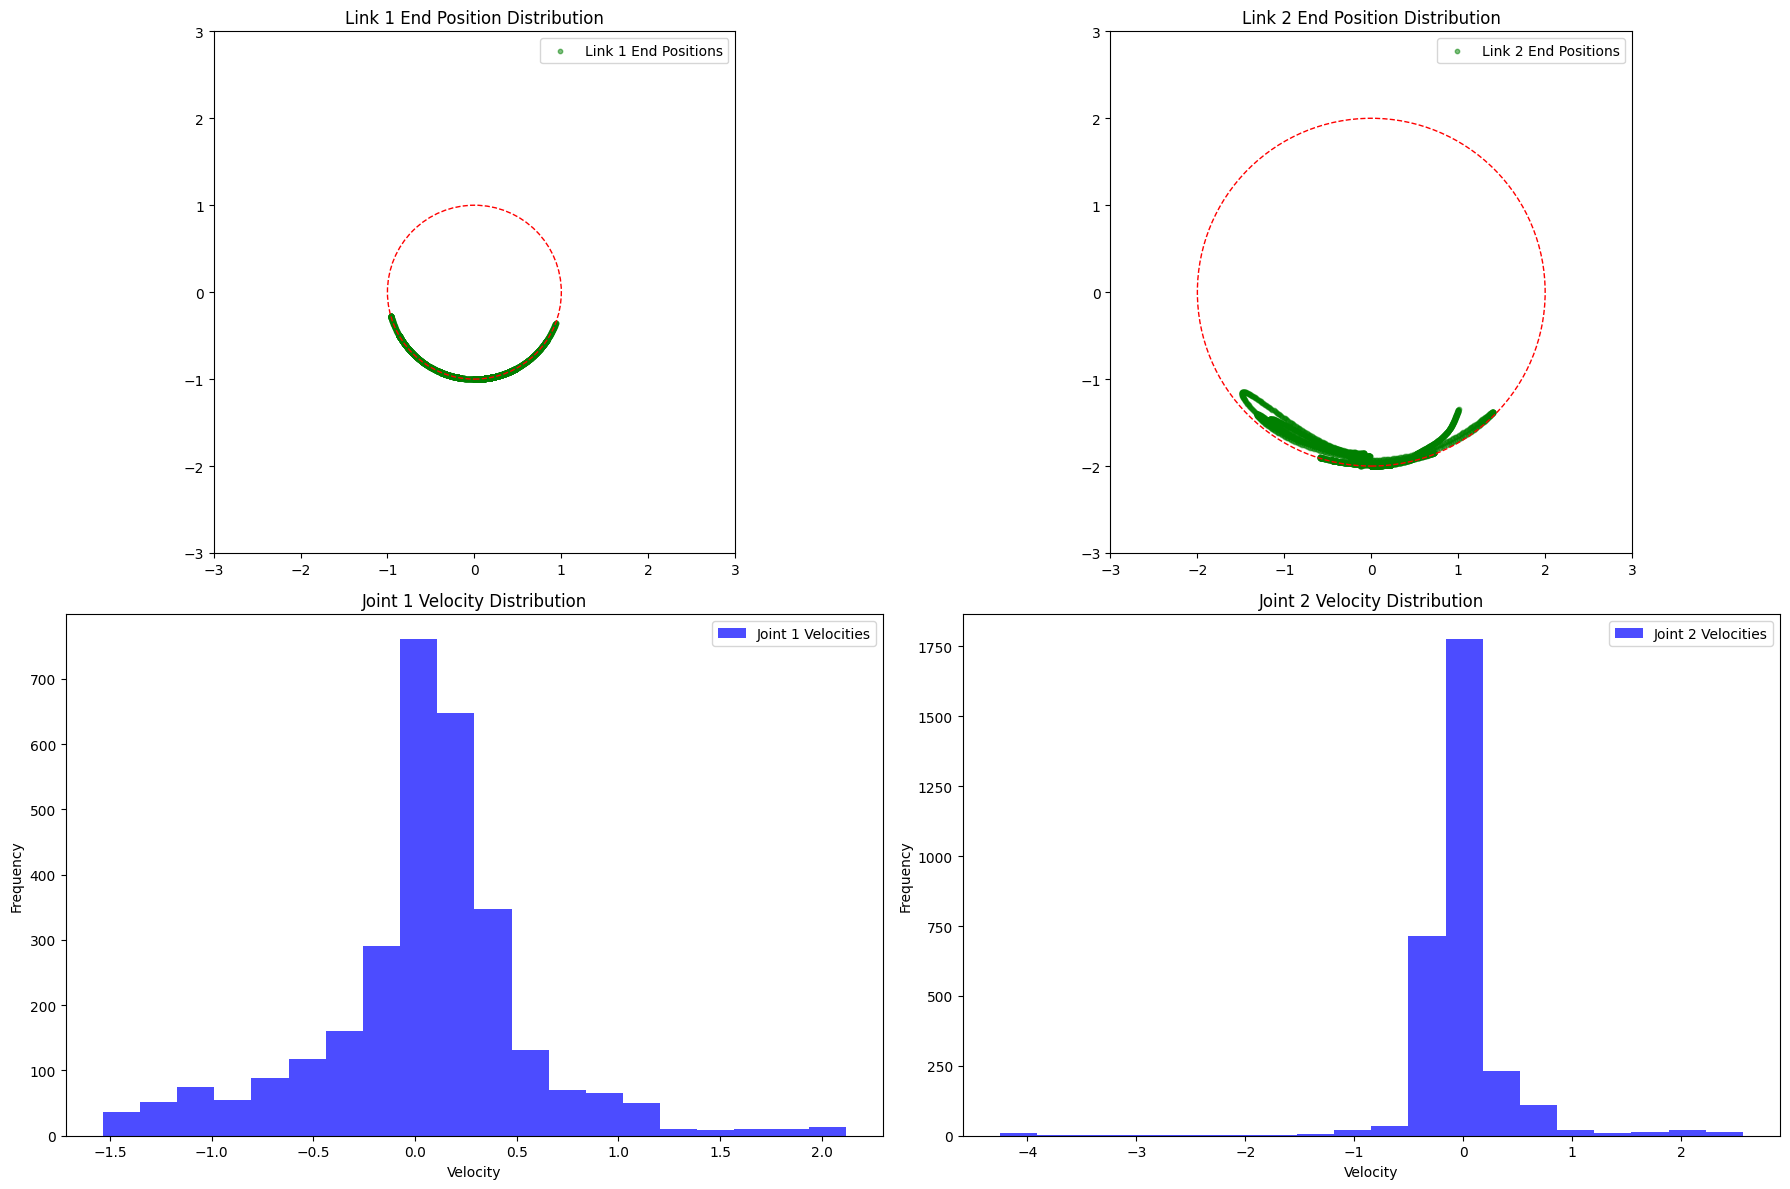

In [10]:
# Plot the distribution of collected samples
plot_positions_velocities_with_fixed_bounds(data['Y'], [1,1])

## Part 2.2: Learning Forward Dynamics

### Training

After the data is collected, you will then need to complete the cell below to use the collected dataset to learn the forward dynamics.

The code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This cell should save the model that it trains. You should use a specific procedure for saving, outlined below. Note that the saving code is not already included so you will have to add it yourself.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints, such that you have a wider range of models to choose from. We provide a code snippet for you and for each epoch of your training, you should use it to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(model_dir, model_folder_name)):
    os.makedirs(os.path.join(model_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics_pt2.pth'))
```

The output from running this code should be a folder as below:

```
models/
    2025-03-08_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics_pt2.pth
        epoch_0002_loss_0.00009413/
            dynamics_pt2.pth   
        ...  
```

You can see that every time you run this cell, a folder whose name is the time you started will be created under `models`. Checkpoints from all epochs will be saved and then the folder name for saving the checkpoint indicates the epoch number and loss on the holdout test set. Recording checkpoints this way allows you to easily pick the model with the smallest loss.

### Important: choosing the best model

Your code should keep track of the checkpoint with the smallest loss on the test set. You should save the path of that checkpoint to the variable `model_path`. An example value of `model_path` could be `models/2025-03-07_20-14-32/epoch_0046_loss_0.00000005/dynamics_pt2.pth`. In the evaluation code, the checkpoint from `model_path` will be loaded and evaluated.

You should also download the `dynamics_pt2.pth` file to include in your submission.

A common practice with regards to model saving is to only save models with the best test_loss, rather than checkpoint every epoch. If you want, you can modify the save code to do that instead.

### Model Architecture

In lecture, we introduced the trick to use joint accelerations to compute the next state. You will use your neural network to compute the joint accelerations. This will take in your joint angles, joint velocities, and actions applied to the arm and output joint acceleration values for each link. Then you can use your knowledge of analytical kinematics to derive the joint positions and velocities in the next time step given the joint acceleration values.

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch
import torch.nn as nn
import argparse
import time
import pickle
np.set_printoptions(suppress=True)


class DynamicDataset(Dataset):
    def __init__(self, data_file):
        data = pickle.load(open(data_file, "rb" ))
        # X: (N, 6), Y: (N, 4)
        self.X = data['X'].astype(np.float32)
        self.Y = data['Y'].astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 64)  # Input: joint angles(2), velocities(2), actions(2) - 6 total values
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)  # Output: joint accelerations (2 values) - 2-link robotic arm

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function on the output
        return x

def train(model):

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    criterion = nn.MSELoss()

    total_loss = 0
    dt = 0.01

    for X, Y in train_loader:

        X = X.to(device)
        Y = Y.to(device)
        #print(f"X shape: {X.shape}")
        #print(f"Y shape: {Y.shape}")
        #print(f"X: {X}")
        #print(f"Y: {Y}\n")

        # Initial positions and velocities
        """
        The state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second)
        The shape of data['X'] should be (num_samples, 6), the first 4 elements are state and the last 2 elements are the action.
        The shape of data['Y'] should be (num_samples, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher.
        """
        initial_positions = X[:, :2]
        initial_velocities = X[:, 2:4]
        #print(f"Initial positions: {initial_positions}")
        #print(f"Initial positions shape: {initial_positions.shape}\n")
        #print(f"Initial velocities: {initial_velocities}")
        #print(f"Initial velocities shape: {initial_velocities.shape}\n")

        optimizer.zero_grad()

        # Accelerations
        joint_accelerations = model(X)
        #print(f"Joint accelerations: {joint_accelerations}")
        #print(f"Joint accelerations shape: {joint_accelerations.shape}\n")

        # Compute new state using kinematics
        new_joint_velocities = initial_velocities + joint_accelerations * dt
        new_joint_positions = initial_positions + new_joint_velocities * dt
        new_state = torch.cat((new_joint_positions, new_joint_velocities), dim=1)

        # Loss function
        loss = criterion(new_state, Y)

        # Backprop
        loss.backward()

        # Adam optimizer
        optimizer.step()

        # Compute total loss
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    #print(f"\nTraining loss: {train_loss:.4f}")

    return train_loss

def test(model):

    model.eval()
    criterion = nn.MSELoss()

    total_loss = 0
    dt = 0.01

    with torch.no_grad():
        for X, Y in test_loader:

            X = X.to(device)
            Y = Y.to(device)

            # Initial positions and velocities
            initial_positions = X[:, :2]
            initial_velocities = X[:, 2:4]

            # Accelerations
            joint_accelerations = model(X)

            # Compute new state using kinematics
            new_joint_velocities = initial_velocities + joint_accelerations * dt
            new_joint_positions = initial_positions + new_joint_velocities * dt
            new_state = torch.cat((new_joint_positions, new_joint_velocities), dim=1)

            # Loss function
            loss = criterion(new_state, Y)
            total_loss += loss.item()

    test_loss = total_loss / len(test_loader)
    #print(f"\nTesting loss: {test_loss:.4f}")

    return test_loss

# The ratio of the dataset used for testing
split = 0.2

# Do NOT change
# We are only using CPU, and GPU is not allowed.
device = torch.device("cpu")

dataset = DynamicDataset('data_pt2.pkl')
dataset_size = len(dataset)
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True)

# The name of the directory to save all the checkpoints
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models', timestr)

# Keep track of the checkpoint with the smallest test loss and save in model_path
model_path = None

# Model setup
model = Net().to(device)

# Initialize best loss
best_loss = float('inf')  # Start with an infinitely large loss

epochs = 50
for epoch in range(1, 1 + epochs):

    # Train the model
    train_loss = train(model)

    # Evaluate the model
    test_loss = test(model)

    # Track the best model based on the lowest test loss and save the best model
    if test_loss < best_loss:

        # Set new best loss
        best_loss = test_loss

        # Save the model in the correct file path
        model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
        model_path = os.path.join(model_dir, model_folder_name, 'dynamics_pt2.pth')

        # Create the directory if it doesn't exist
        if not os.path.exists(os.path.join(model_dir, model_folder_name)):
            os.makedirs(os.path.join(model_dir, model_folder_name))

        # Save the model
        torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics_pt2.pth'))

    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}')

# After training, print out the best model path
print(f'\nBest model saved at: {model_path}')

# Print best loss
print(f'Best loss: {best_loss}')

Epoch [1/50], Train Loss: 0.00039718, Test Loss: 0.00023317
Epoch [2/50], Train Loss: 0.00009794, Test Loss: 0.00001606
Epoch [3/50], Train Loss: 0.00003495, Test Loss: 0.00001123
Epoch [4/50], Train Loss: 0.00002613, Test Loss: 0.00000919
Epoch [5/50], Train Loss: 0.00002609, Test Loss: 0.00003824
Epoch [6/50], Train Loss: 0.00001971, Test Loss: 0.00000755
Epoch [7/50], Train Loss: 0.00001681, Test Loss: 0.00002213
Epoch [8/50], Train Loss: 0.00002118, Test Loss: 0.00001082
Epoch [9/50], Train Loss: 0.00001413, Test Loss: 0.00002446
Epoch [10/50], Train Loss: 0.00001358, Test Loss: 0.00000585
Epoch [11/50], Train Loss: 0.00001286, Test Loss: 0.00003221
Epoch [12/50], Train Loss: 0.00001200, Test Loss: 0.00000508
Epoch [13/50], Train Loss: 0.00001124, Test Loss: 0.00000510
Epoch [14/50], Train Loss: 0.00000877, Test Loss: 0.00000223
Epoch [15/50], Train Loss: 0.00001162, Test Loss: 0.00000587
Epoch [16/50], Train Loss: 0.00000746, Test Loss: 0.00000661
Epoch [17/50], Train Loss: 0.0000

## Prediction

After you are done with training, you need to complete the cell below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [12]:
import torch
import numpy as np
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        self.model = Net()
        self.model.to(device)
        self.device = device
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):

        """
        dynamics_step
            - a method for forward simulation of the dynamics of the system using an Euler integration method
            - it calculates the next state of the system based on the current state, action, and time step
        """

        if self.model_loaded:

            # Current state
            #print(f"Current state: {state.reshape(-1)}")
            #print(f"Current state shape: {state.shape}\n")

            # Concacatenate state and action to calculate the next state
            next_state = np.concatenate((state.reshape(-1), action.reshape(-1)), axis=0)
            #print(f"Next state: {next_state}")
            #print(f"Next state shape: {next_state.shape}\n")

            # Convert to tensors
            #next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device).unsqueeze(0)
            next_state = torch.tensor(next_state).float().to(self.device).unsqueeze(0)
            #print(f"Next state tensor: {next_state}")
            #print(f"Next state tensor shape: {next_state.shape}\n")

            # Predict joint accelerations
            with torch.no_grad():
                joint_accelerations = self.model(next_state).cpu().numpy().flatten()
                #print(f"Joint accelerations: {joint_accelerations}")
                #print(f"Joint accelerations: {joint_accelerations.shape}")

            # Compute new state using kinematics
            new_joint_velocities = state[2:4, :].reshape(-1) + joint_accelerations * dt
            new_joint_positions = state[:2, :].reshape(-1) + new_joint_velocities * dt
            #new_state = np.cat((new_joint_positions, new_joint_velocities))
            new_state = np.concatenate((new_joint_positions, new_joint_velocities)).reshape(4, 1)

            return new_state
        else:
            return state

## Evaluation and Grading

The total number of points for this part is 5. There are 3 types of tests. Your grade for this part will be the average score across each type of test

**For each type, there are 50 tests.** For each test, you get a score of 1, 0.5, or 0. Your final grade for each type is the averaged score across 50 tests * 5.

- *Type 1*: for each test, a constant torque randomly sampled from [-1.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If the MSE (Mean Squred Error) between the predicted arm state (arm_student) and the ground truth arm state (arm_teacher) is < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 2*: for each test, a torque that linearly increases from 0 to a random torque in [0.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If MSE < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 3*: for each test, one torque is applied for the first 2.5 seconds and another torque is applied for the remaining 2.5 seconds. Both torques are sampled from [-1Nm, 1Nm]. If MSE < 0.015, you get score 1 for this test. If 0.015 <= MSE < 0.05, you get score 0.5 for this test. Otherwise you get 0.


In [13]:
# DO NOT CHANGE
# Set up grading


import importlib
import score
importlib.reload(score)

# Make sure model_path is correctly set
print(model_path)

# Create the teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
arm_teacher = Robot(dynamics_teacher)

# Create the student arm
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
if model_path is not None:
  dynamics_student.init_model(model_path, num_links=2, time_step=0.01, device=torch.device('cpu'))
arm_student = Robot(dynamics_student)

models/2025-04-02_00-51-59/epoch_0040_loss_0.00000083/dynamics_pt2.pth


In [14]:
# DO NOT CHANGE

# Test on randomly sampled torques from [-1.5, 1.5]
score.score_random_torque(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque = 0.542641286533492 Nm)

average mse: 0.002521366275920048
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 2 (Torque = -0.958496101281197 Nm)

average mse: 0.0014284058231208738
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 3 (Torque = 0.26729646985255084 Nm)

average mse: 0.0039375427047101605
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 4 (Torque = 0.4976077650772237 Nm)

average mse: 0.0012354421907833817
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 5 (Torque = -0.0029859753948191514 Nm)

average mse: 0.0007763980768630686
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 6 (Torque = -0.5504067089383047 Nm)

average mse: 0.001921617992668901
Score: 0.5/1
-

In [15]:
# DO NOT CHANGE

# Test on torques that linearly increase from 0 to a random number from [0.5, 1.5]
score.score_linear_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 0 -> 0.8856603216333729 Nm)

average mse: 0.0007270448594140104
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 0 -> 0.5103759746797008 Nm)

average mse: 0.0006581457860248115
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 0 -> 0.8168241174631377 Nm)

average mse: 0.0007715953617193369
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 0 -> 0.8744019412693059 Nm)

average mse: 0.0007295519820374168
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 0 -> 0.7492535061512953 Nm)

average mse: 0.0008337395449099693
Score: 0.5/1
----------------------------------------


----------------------------------------
TEST 6 (Torque 0 -> 0.6123983227654238 Nm)

average mse: 0.0008272643628136387

In [16]:
# DO NOT CHANGE

# Test on one torque applied to the first 2.5s and another torque applied to the second 2.5s
# Both torques are sampled from [-1, 1]
score.score_two_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 1 = 0.542641286533492 Nm,  Torque 2 = -0.21494151210682544 Nm)

average mse: 0.0049203306197485395
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 1 = -0.958496101281197 Nm,  Torque 2 = -0.8130792508826994 Nm)

average mse: 0.002986922811070442
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 1 = 0.26729646985255084 Nm,  Torque 2 = 0.6422113156738569 Nm)

average mse: 0.007362672790622827
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 1 = 0.4976077650772237 Nm,  Torque 2 = -0.6976959607148723 Nm)

average mse: 0.005318542813034885
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 1 = -0.0029859753948191514 Nm,  Torque 2 = -0.23177110261560085 Nm)

average mse: 0.0009648277965895365
Score:

# Part 3: MPC Controller with Learned Dynamics Model

## Part 3.1: Model Architecture

We have a base class Model and a subclass for the 2-link arm. The class Model is a base class for our models. In compute_next_state() method, you have to use the trick to use joint accelerations to compute the next state similar to what you did in Part 2.

In the `Model2Link` class you will use a neural network to compute the joint accelerations by implementing `compute_qddot()` method. This will take 6 values (2 joint angles, 2 joint velocities and 2 actions applied to the arm) and output 2 joint acceleration values

Do not change the arguments for the `__init__()` method even if you do not use them.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
		def __init__(self, num_links, time_step):
				super().__init__()
				self.num_links = num_links
				self.time_step = time_step

		def forward(self, x):
				qddot = self.compute_qddot(x)
				state = x[:, :2*self.num_links]
				next_state = self.compute_next_state(state, qddot)
				return next_state

		def compute_next_state(self, state, qddot):

				"""Use joint accelerations to compute the next state"""

				# Positions
				q = state[:, :self.num_links]

				# Velocities
				qdot = state[:, self.num_links:]

				# Integrate velocity to get position
				q_next = q + qdot * self.time_step

				# Integrate acceleration to get velocity
				qdot_next = qdot + qddot * self.time_step

				# Next state
				next_state = torch.cat([q_next, qdot_next], dim=1)

				return next_state

		def compute_qddot(self, x):
				pass

class Model2Link(Model):

		def __init__(self, time_step):
				super().__init__(2, time_step)

				"""Use a neural network to compute the joint accelerations by implementing compute_qddot() method
				This will take 6 values (2 joint angles, 2 joint velocities and 2 actions applied to the arm) and output 2 joint acceleration values"""

				self.fc1 = nn.Linear(6, 64)  # Input: joint angles(2), velocities(2), actions(2) - 6 total values
				self.fc2 = nn.Linear(64, 128)
				self.fc3 = nn.Linear(128, 64)
				self.fc4 = nn.Linear(64, 2)  # Output: joint accelerations (2 values) - 2-link robotic arm

		def compute_qddot(self, x):

				# Forward pass
				x = torch.relu(self.fc1(x))
				x = torch.relu(self.fc2(x))
				x = torch.relu(self.fc3(x))
				x = self.fc4(x)  # No activation function on the output
				return x

## Part 3.2: Collect Data
Similar to part 2, we will collect data which will be used to learn a forward model for our 2 link robot arm. Once we have learnt a forward model you will be evaluated on your MPC Controller that uses the learnt dynamics model instead of the true dynamics.

You can modify the collect_data function or write any of your own functions however you choose to. You will be evaluated on the **2 Link Robot**

In [18]:
import numpy as np
import random
import math
import time

# Teacher arm with 2 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

# Seeding - the randomly initialized weights of the neural network should be made repeatable using seeding
def set_seed(seed_value=42):
    random.seed(seed_value)        # Python's random module
    np.random.seed(seed_value)     # NumPy

# Simulation function for collecting data
def simulate_torque(torque_type, num_steps, initial_state, arm_teacher):

    # Store X dataset (state + action) and Y dataset (next state)
    X = np.zeros((num_steps, arm_teacher.dynamics.get_state_dim() + arm_teacher.dynamics.get_action_dim()))
    Y = np.zeros((num_steps, arm_teacher.dynamics.get_state_dim()))

    # Set initial state
    arm_teacher.set_state(initial_state)

    for step in range(num_steps):
        if torque_type == "random":  # Random torque scenario
            action = np.random.uniform(-1.5, 1.5, size=(arm_teacher.dynamics.get_action_dim(), 1))

        elif torque_type == "linear":  # Linearly increasing torque scenario
            start_torque = np.linspace(0.5, 1.5, 30)[step % 30]
            action = np.array([[start_torque * (step / num_steps)], [0]])

        elif torque_type == "two":  # Two torque scenario
            if step < num_steps // 2:
                torque = np.linspace(-1, 1, 30)[step % 30]
            else:
                torque = np.linspace(-1, 1, 30)[-(step % 30)]
            action = np.array([[torque], [0]])

        else:
            raise ValueError("Unknown torque type")

        # Apply action and collect data
        state = arm_teacher.get_state().flatten()
        arm_teacher.set_action(action)
        arm_teacher.advance()
        next_state = arm_teacher.get_state().flatten()

        X[step, :] = np.concatenate((state, action.flatten()))
        Y[step, :] = next_state

    return X, Y

# Control the arm to collect a dataset for training the forward dynamics.
def collect_data(arm):

    num_samples = 10000  # Total number of steps
    torque_types = ["random", "linear", "two"]  # Torque scenarios
    set_seed(seed_value=42)  # Seeding for reproducibility

    # Define initial state
    initial_state = np.zeros((arm.dynamics.get_state_dim(), 1))
    initial_state[0] = -math.pi / 2.0

    set_seed(seed_value=42)

    # Collect data for each torque type
    all_results = [simulate_torque(torque_type, num_samples, initial_state, arm) for torque_type in torque_types]

    # Combine results into X and Y
    X = np.concatenate([result[0] for result in all_results], axis=0)
    Y = np.concatenate([result[1] for result in all_results], axis=0)

    return X, Y

In [19]:
import pickle

# Call the function you have defined above to collect data
X, Y = collect_data(arm)
save_dir = 'dataset'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

# Save the collected data in the data_pt3.pkl file
data = {'X': X, 'Y': Y}
pickle.dump(data, open(os.path.join(save_dir, 'data_pt3.pkl'), "wb" ))

## Part 3.3: Training the forward model
By now you would be familiar with the basic skeleton of training a forward model.

The starter code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This script should save the model that it trains. You should use a specific procedure for saving, outlined below.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints. Our starter code already configures save_dir for you and for each epoch of your training, you should use the following code to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(args.save_dir, model_folder_name)):
    os.makedirs(os.path.join(args.save_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(args.save_dir, model_folder_name, 'dynamics_pt3.pth'))
print(f'model saved to {os.path.join(args.save_dir, model_folder_name, "dynamics_pt3.pth")}\n')
```
The output from running this code should be a folder as below:

```
models/
    2021-03-24_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics_pt3.pth
        epoch_0002_loss_0.00009413/
            dynamics_pt3.pth   
        ...  
```
You can implement the functions below as you please to collect data

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import pickle
import torch.optim as optim
import argparse
import time

class DynamicDataset(Dataset):
    def __init__(self, datafile):
        data = pickle.load(open(datafile, 'rb'))
        # X: (N, 6), Y: (N, 4)
        self.X = data['X'].astype(np.float32)
        self.Y = data['Y'].astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def train_one_epoch(model, optimizer, criterion, train_loader, device):

    model.train()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    #criterion = nn.MSELoss()

    total_loss = 0
    dt = 0.01

    for X, Y in train_loader:

        X = X.to(device)
        Y = Y.to(device)
        #print(f"X shape: {X.shape}")
        #print(f"Y shape: {Y.shape}")
        #print(f"X: {X}")
        #print(f"Y: {Y}\n")

        # Initial positions and velocities
        """
        The state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second)
        The shape of data['X'] should be (num_samples, 6), the first 4 elements are state and the last 2 elements are the action.
        The shape of data['Y'] should be (num_samples, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher.
        """
        #initial_positions = X[:, :2]
        #initial_velocities = X[:, 2:4]
        #print(f"Initial positions: {initial_positions}")
        #print(f"Initial positions shape: {initial_positions.shape}\n")
        #print(f"Initial velocities: {initial_velocities}")
        #print(f"Initial velocities shape: {initial_velocities.shape}\n")

        optimizer.zero_grad()

        # Accelerations
        joint_accelerations = model(X)
        #print(f"Joint accelerations: {joint_accelerations}")
        #print(f"Joint accelerations shape: {joint_accelerations.shape}\n")

        # Compute new state using kinematics
        #new_joint_velocities = initial_velocities + joint_accelerations * dt
        #new_joint_positions = initial_positions + new_joint_velocities * dt
        #new_state = torch.cat((new_joint_positions, new_joint_velocities), dim=1)

        # Loss function
        #loss = criterion(new_state, Y)
        loss = criterion(joint_accelerations, Y)

        # Backprop
        loss.backward()

        # Adam optimizer
        optimizer.step()

        # Compute total loss
        total_loss += loss.item() * X.size(0)

    train_loss = total_loss / len(train_loader)
    #print(f"\nTraining loss: {train_loss:.4f}")

    return train_loss

def test(model, criterion, test_loader, device):

    model.eval()
    #criterion = nn.MSELoss()

    total_loss = 0
    dt = 0.01

    with torch.no_grad():
        for X, Y in test_loader:

            X = X.to(device)
            Y = Y.to(device)

            # Initial positions and velocities
            #initial_positions = X[:, :2]
            #initial_velocities = X[:, 2:4]

            # Accelerations
            joint_accelerations = model(X)

            # Compute new state using kinematics
            #new_joint_velocities = initial_velocities + joint_accelerations * dt
            #new_joint_positions = initial_positions + new_joint_velocities * dt
            #new_state = torch.cat((new_joint_positions, new_joint_velocities), dim=1)

            # Loss function
            #loss = criterion(new_state, Y)
            loss = criterion(joint_accelerations, Y)

            # Compute total loss
            total_loss += loss.item() * X.size(0)

    test_loss = total_loss / len(test_loader)
    #print(f"\nTesting loss: {test_loss:.4f}")

    return test_loss

def train_forward_model():

    # Keep track of the checkpoint with the smallest test loss and save in model_path
    model_path = None
    max_test_loss = 1e4
    model = Model2Link(0.01)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    criterion = nn.MSELoss()

    device = torch.device("cpu")

    datafile = 'dataset/data_pt3.pkl'
    split = 0.2

    dataset = DynamicDataset(datafile)
    dataset_size = len(dataset)
    test_size = int(np.floor(split * dataset_size))
    train_size = dataset_size - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

    # The name of the directory to save all the checkpoints
    timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
    model_dir = os.path.join('models', timestr)

    # Initialize best loss
    best_loss = float('inf')  # start with infinitely large loss

    epochs=50
    for epoch in range(1, 1 + epochs):
        # Train the model
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)

        # Evaluate the model
        test_loss = test(model, criterion, test_loader, device)

        # Track the best model based on the lowest test loss and save the best model
        if test_loss < best_loss:

            # Set new best loss
            best_loss = test_loss

            #model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
            #if not os.path.exists(os.path.join(args.save_dir, model_folder_name)):
                #os.makedirs(os.path.join(args.save_dir, model_folder_name))
            #torch.save(model.state_dict(), os.path.join(args.save_dir, model_folder_name, 'dynamics_pt3.pth'))
            #print(f'model saved to {os.path.join(args.save_dir, model_folder_name, "dynamics_pt3.pth")}\n')

            # Save the model in the correct file path
            model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
            model_path = os.path.join(model_dir, model_folder_name, 'dynamics_pt3.pth')

            # Create the directory if it doesn't exist
            if not os.path.exists(os.path.join(model_dir, model_folder_name)):
                os.makedirs(os.path.join(model_dir, model_folder_name))

            # Save the model
            torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics_pt3.pth'))

        print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}')

    # Print model path
    #print(f'\nModel path: {model_path}')

    # After training, print out the best model path
    print(f'\nBest model saved at: {model_path}')

    # Print best loss
    print(f'Best loss: {best_loss}')

    return model_path

In [21]:
model_path = train_forward_model()

Epoch [1/50], Train Loss: 0.57203271, Test Loss: 0.11409714
Epoch [2/50], Train Loss: 0.10708860, Test Loss: 0.09924033
Epoch [3/50], Train Loss: 0.07155224, Test Loss: 0.05092129
Epoch [4/50], Train Loss: 0.03744429, Test Loss: 0.02730719
Epoch [5/50], Train Loss: 0.02115446, Test Loss: 0.01460891
Epoch [6/50], Train Loss: 0.01191319, Test Loss: 0.02387849
Epoch [7/50], Train Loss: 0.00846123, Test Loss: 0.00932957
Epoch [8/50], Train Loss: 0.00728727, Test Loss: 0.00611493
Epoch [9/50], Train Loss: 0.00624583, Test Loss: 0.00624351
Epoch [10/50], Train Loss: 0.00567114, Test Loss: 0.00447724
Epoch [11/50], Train Loss: 0.00480061, Test Loss: 0.00534058
Epoch [12/50], Train Loss: 0.00439275, Test Loss: 0.00357072
Epoch [13/50], Train Loss: 0.00431657, Test Loss: 0.00388622
Epoch [14/50], Train Loss: 0.00388732, Test Loss: 0.00326411
Epoch [15/50], Train Loss: 0.00362477, Test Loss: 0.00421585
Epoch [16/50], Train Loss: 0.00330226, Test Loss: 0.00327520
Epoch [17/50], Train Loss: 0.0034

## Part 3.4: Completing ArmDynamicsStudent

After you are done with training, you need to complete ArmDynamicsStudent class following the comments below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [22]:
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):

        # Initialize the model loading the saved model from provided model_path
        self.model = Model2Link(time_step).to(device)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.to(device)
        self.model.eval()
        self.device = device
        self.model_loaded = True

        print(f"Model loaded from {model_path}")

    def dynamics_step(self, state, action, dt):

        """
        dynamics_step
            - a method for forward simulation of the dynamics of the system using an Euler integration method
            - it calculates the next state of the system based on the current state, action, and time step
        """

        if self.model_loaded:

            # Current state
            #print(f"Current state: {state.reshape(-1)}")
            #print(f"Current state shape: {state.shape}\n")

            # Current action
            #print(f"Current action: {action.reshape(-1)}")
            #print(f"Current action shape: {action.shape}\n")

            # Use the loaded model to predict new state given the current state and action
            current_state = torch.tensor(state).float().to(self.device).view(1, -1)
            current_action = torch.tensor(action).float().to(self.device).view(1, -1)

            # Concacatenate state and action to calculate the next state
            #next_state = np.concatenate((state.reshape(-1), action.reshape(-1)), axis=0)
            #print(f"Next state: {next_state}")
            #print(f"Next state shape: {next_state.shape}\n")

            # Convert to tensors
            next_state = torch.cat((current_state, current_action), dim=1)
            #next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device).unsqueeze(0)
            #next_state = torch.tensor(next_state).float().to(self.device).unsqueeze(0)
            #print(f"Next state tensor: {next_state}")
            #print(f"Next state tensor shape: {next_state.shape}\n")

            # Predict joint accelerations
            with torch.no_grad():
                joint_accelerations = self.model(next_state)#.cpu().numpy().squeeze(0)
                #print(f"Joint accelerations: {joint_accelerations}")
                #print(f"Joint accelerations: {joint_accelerations.shape}")

            # Compute new state using kinematics
            #new_joint_velocities = state[2:4, :].reshape(-1) + joint_accelerations * dt
            #new_joint_positions = state[:2, :].reshape(-1) + new_joint_velocities * dt
            #new_state = np.cat((new_joint_positions, new_joint_velocities))
            #new_state = np.concatenate((new_joint_positions, new_joint_velocities)).reshape(4, 1)
            #new_state = state.copy()
            #new_state[2:] += joint_accelerations * dt  # Update velocities
            #new_state[:2] += new_state[2:] * dt  # Update positions

            #new_state = current_state.cpu().numpy().flatten() + joint_accelerations.squeeze(0)
            new_state = current_state + joint_accelerations.squeeze(0)
            #print(f"New state: {new_state}")
            #print(f"New state shape: {new_state.shape}\n")

            return new_state.cpu().numpy().reshape(-1, 1)
        else:
            return state

print(f"Model used when predicting next state: {model_path}")

Model used when predicting next state: models/2025-04-02_00-57-41/epoch_0047_loss_0.00078316/dynamics_pt3.pth


## Manually Testing the MPC Controller with the learnt dynamics model
We will now use the learnt dynamics model that you have trained. The model is loaded in the dynamics.init_model method. You can modify the goal positions to see how well is the controller performing similar to what you did before. Feel free to play around with the code in this cell to test your performance before the grading part.


In [23]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time

# Teacher arm with 3 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

gui = False
action = np.zeros((arm.dynamics.get_action_dim(), 1))
if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC(dynamics_teacher)
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
device = torch.device('cpu')

# model_path should have the path to the best model that you have trained so far which you would like to use for testing the controller
#model_path = None
model_path = model_path
#model_path = "models/2025-04-01_23-23-08/epoch_0042_loss_0.00042828/dynamics_pt3.pth"
print(f"Model loaded from {model_path}")

# Check if the model file exists before trying to load it
if os.path.exists(model_path):
    dynamics_student.init_model(model_path, 2, 0.01, device)
else:
    print(f"Error: Model file not found at '{model_path}'")

# Control loop
action = np.zeros((arm.dynamics.get_action_dim(), 1))
goal = np.zeros((2, 1))
goal[0, 0] = 2.7
goal[1, 0] = 0.5
arm.goal = goal

dt = 0.01
time_limit = 2.5
num_steps = round(time_limit/dt)
for s in range(num_steps):
  t = time.time()
  arm.advance()

  if gui:
    renderer.plot([(arm, "tab:blue")])
  time.sleep(max(0, dt - (time.time() - t)))

  if s % controller.control_horizon==0:
    state = arm.get_state()
    state = state.reshape(-1)
    action = controller.compute_action(dynamics_student, state, goal, action)
    arm.set_action(action)

Model loaded from models/2025-04-02_00-57-41/epoch_0047_loss_0.00078316/dynamics_pt3.pth
Model loaded from models/2025-04-02_00-57-41/epoch_0047_loss_0.00078316/dynamics_pt3.pth


## Grading and Evaluation of Part 3
You will be evaluated on how well your controller+learnt dynamics works together. The scoring functions consists of 16 random test goals all of which will be below the x axis and between 0.05 to 1.95 lengths away from the origin.
The controller will call the compute_action method from your MPC class and apply the action for 10 timesteps
```
action = controller.compute_action(dynamics_student, state, goal, action)
```

Each test will run the robot arm for **2.5 seconds**. At the end of the 2.5 seconds the test will be:

A success if your end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5`

A partial success if your end effectors meet this criteria:
`distance_to_goal < 0.3 and vel_ee < 0.5`

After all of the tests are complete, your score is summed up and then scaled out of 5 total points. You need 15 out of the 16 tests to succeed to get a full score.

In [26]:
controller = MPC(dynamics_student)
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
#model_path = 'dynamics_pt3.pth'
model_path = model_path
gui=True

KeyboardInterrupt: 

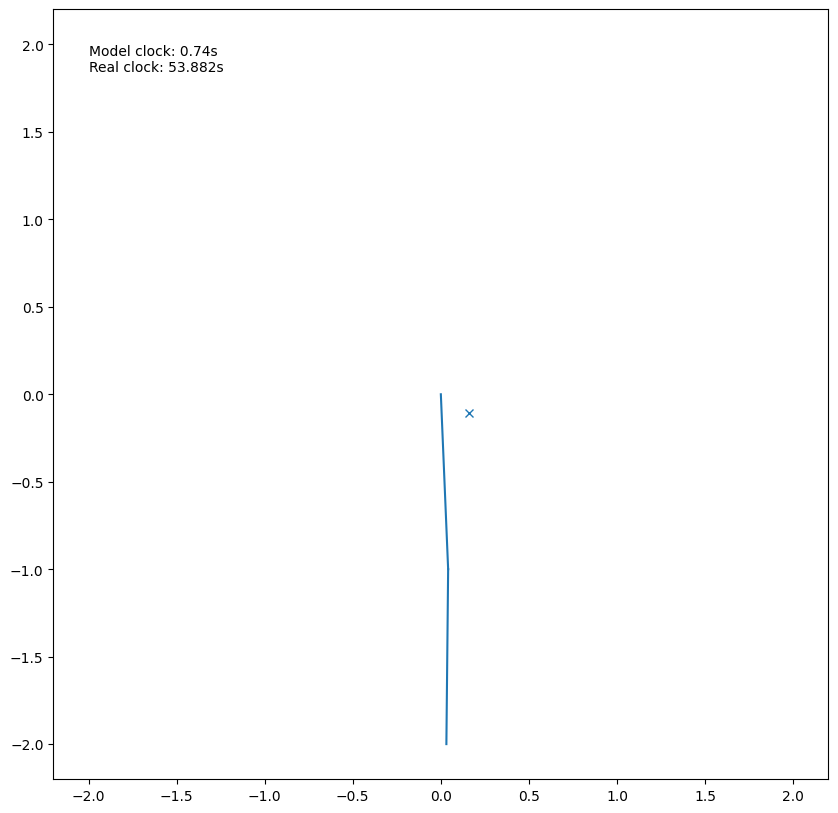

In [27]:
# DO NOT CHANGE
score_mpc_learnt_dynamics(controller, dynamics_student, model_path, gui)

Time Limit
*   MPC evaluation (Part 1): 30 minutes
*   Data Collection with MPC (Part 2): 1 hour 20 minutes
*   Training the forward dynamics model (Part 3): 40 minutes

Note: Time limits are general guidelines. While your code must run within the allotted time, you should be able to achieve full score with a much shorter runtime


Hints and Suggestions:
1. You can use your MPC Controller in your data collection to gather better training samples
2. A good cost function to evaluate your trajectory in MPC is very important and you can use both distance and velocity metrics to define the cost function.
3. As mentioned in the lecture, a constant torque with pseudo gradients seems to work well for this project. You can also use multiple delta values to gather more trajectories to choose from.
4. Since we are passing the MPC object to the controller you can instantiate the MPC class with different parameters like the planning horizon, delta values etc.
5. To speed up data collection, avoid using np.concatenate(), np.stack() or np.append() like functions on your X and Y arrays. Instead, initialize X and Y arrays with all zeros using the correct shape and then fill in the values one by one. This is much faster in numpy. Using Ray is optional

# Other Requirements and Hints

Time Limit
*   MPC evaluation (Part 1): 30 minutes
*   Learned Forward Model (Part 2): Less than a hundred epochs of training (<= 25 mins) should suffice for achieving the full points. Again, the shorter your model training time is the better.
*   Data Collection with MPC (Part 3): 1 hour 20 minutes
*   Training the forward dynamics model (Part 3): 40 minutes

Note: Time limits are general guidelines. While your code must run within the allotted time, you should be able to achieve full score with a much shorter runtime


Hints and Suggestions:
1. Choosing the right policy to collect datasets for this project (parts 2 and 3) is important. You need to think about how to do it properly so that your trained model will pass the tests successfully. It is in general very hard to learn the ground truth forward dynamics completely (that works for any distribution of actions), and during testing small errors can accumulate, leading to drastic failure in the end. You might want to try overfitting on the test cases to begin with.
2. Make sure that your dataset for part 2 is less than 100 Mb, which is pretty much sufficient for achieving full marks. Collecting datasets can be time-consuming and you could parallelize this process for some speed-up using [ray](https://www.ray.io/). Make sure your data collection in part 2 takes <= 25 mins.
3. You can use your MPC Controller in your data collection for part 3 to gather better training samples
4. A good cost function to evaluate your trajectory in MPC is very important and you can use both distance and velocity metrics to define the cost function.
5. As mentioned in the lecture, a constant torque with pseudo gradients seems to work well for this project. You can also use multiple delta values to gather more trajectories to choose from.
6. Since we are passing the MPC object to the controller you can instantiate the MPC class with different parameters like the planning horizon, delta values etc.
7. To speed up data collection, avoid using np.concatenate(), np.stack() or np.append() like functions on your X and Y arrays. Instead, initialize X and Y arrays with all zeros using the correct shape and then fill in the values one by one. This is much faster in numpy. Using Ray is optional
8. You may reuse your part 2 model for part 3, but it may be beneficial to re-collect data to train a model specific to part 3.

General Tips and Requirements
- NO GPU: No GPU is required or allowed for this assignment and we will test your code without GPUs.
- Loss Function: This is essentially a regression problem so think about what losses are suitable for regression.
- Optimizer: While it is possible to use a simple optimizer to achieve the desired accuracy, the training time can be quite high. There exists a number of optimizers implemented in PyTorch that have much faster convergence.
- Seeding. Please use seeding in your code to make sure your results are reproducible.